<a href="https://colab.research.google.com/github/mariobecerra/mda_project/blob/main/code/04_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**01) mkdata**

In [1]:
data_url = "https://raw.githubusercontent.com/mariobecerra/mda_project/meta-analysis/code/out/meta_analysis_data.csv"



In [2]:
if(!require("dlnm")) install.packages("dlnm")
if(!require("splines")) install.packages("splines")
if(!require("xtable")) install.packages("xtable")
if(!require("mvmeta")) install.packages("mvmeta")



Loading required package: dlnm

This is dlnm 2.4.7. For details: help(dlnm) and vignette('dlnmOverview').

Loading required package: splines

Loading required package: xtable

Loading required package: mvmeta

This is mvmeta 1.0.3. For an overview type: help('mvmeta-package').



In [3]:
# LOAD THE DATA
data <- read.csv(data_url)

# Excluding region La Louvière, as the mortality data was unavailable
data <- data[data$Nom_arrondissement != "La Louvière",]

In [4]:
####################################################################
# REGIONS

regions <- as.character(unique(data$Nom_arrondissement))

####################################################################
# LIST OF DATAFRAMES FOR OUR REGIONS

datalist <- lapply(regions, function(region) data[data$Nom_arrondissement==region,])
names(datalist) <- regions

####################################################################
# CITY-LEVEL META-PREDICTORS

lat <- c(50.9407, 51.2213, 49.6855, 50.6340, 50.8459, 50.0006, 51.2092, 50.8260,
         50.4096, 50.8268, 51.0255, 51.0317, 50.2607, 51.1852, 51.0500, 50.8135,
         50.9326, 50.5187, 50.8823, 50.6330, 51.0963, 50.2297, 51.0259, 50.4547,
         50.7431, 50.4649, 49.8417, 50.5992, 51.2247, 50.1960, 50.9499, 51.1653,
         50.5793, 50.3406, 51.0000, 50.7800, 50.6055, 51.3217, 50.5911, 51.0732,
         49.5673, 50.6981, 50.8492)
perclat <- round(quantile(lat,c(1,3)*0.25),1)

####################################################################
# ADDITIONAL INFO

m <- length(datalist)

# MOVING AVERAGE OF TMEAN OVER LAG 0-6
for(i in seq(datalist)) datalist[[i]]$tmean05 <- 
  filter(datalist[[i]]$tmean,rep(1,6)/6,side=1)

# TEMPERATURE RANGES (FOR LAG 0-5)
ranges <- t(sapply(datalist,function(x) range(x$tmean05,na.rm=T)))

# COMPUTE 25TH-75TH PERCENTILES OF META-VARIABLES

# DEFINE THE AVERAGE RANGE, CENTERING POINT, DEGREE AND TYPE OF THE SPLINE
# (THESE PARAMETERS CAN BE CHANGED BY THE USER FOR ADDITIONAL ANALYSES)
cen <- 17
bound <- colMeans(ranges)
degree <- 2
type <- "bs"
df <- 6

# DEFINE THE KNOTS AT TEMPERATURE CORRESPONDING TO AVERAGE PERCENTILES
knotperc <- c(5,35,65,95)
knots <- rowMeans(sapply(datalist,function(x) 
  quantile(x$tmean05,knotperc/100,na.rm=T)))

**02) Stage 1**

In [6]:
####################################################################
# RUN THE FIRST STAGE MODEL
#   COMPUTING TIME IS ~12SEC (IN A 2.66GHz-4GBRAM PC UNDER WINDOWS)
####################################################################

# BUILT OBJECTS WHERE RESULTS WILL BE STORED:
#   ymat IS THE MATRIX FOR THE OUTCOME PARAMETERS
#   Slist IS THE LIST WITH (CO)VARIANCE MATRICES
ymat <- matrix(NA, 
               m, 
               df, 
               dimnames=list(regions, paste("spl", seq(df), sep="")))
Slist <- vector("list",m)
names(Slist) <- regions

####################################################################
# RUN THE FIRST-STAGE ANALYSIS

# WARNING FOR PREDICTION BEYOND BOUNDARIES SUPPRESSED
options(warn = -1)

system.time(
for(i in seq(m)) {
  

  # LOAD
  data <- datalist[[i]]

  # CREATE THE SPLINE
  # NB: KNOTS AND BOUNDARIES FIXED AT SAME VALUES
  btmean05 <- onebasis(data$tmean05,
                       fun = type,
                       degree = degree,
                       knots = knots,
                       Bound = bound)

  # RUN THE MODEL
  model <- glm(N_DEATHS ~ btmean05 + DOW + ns(TIME,7*14),
               family = quasipoisson(),
               data,
               na.action = na.exclude)
	
  # EXTRACT AND SAVE THE RELATED COEF AND VCOV
  predtmean05 <- crosspred(btmean05, model, cen=cen)
  ymat[i,] <- predtmean05$coef
  Slist[[i]] <- predtmean05$vcov
})

# RESET WARNING
options(warn = 0)




   user  system elapsed 
 10.051   0.086  10.163 

**03) MV & Pred**

In [7]:
####################################################################
# 1) RUN THE MODELS WITH mvmeta
#
# 2) CREATE BASIS VARIABLES USING onebasis, USED FOR PREDICTION
#
# 3) PREDICT THE OUTCOME PARAMETERS OVER SPECIFIC VALUES OF STUDY-LEVEL
#   COVARIATES USING predict (mvmeta),THEN RE-BUILD THE PREDICTED CURVE AT
#   THOSE VALUES USING crosspred AGAIN
#
# NOTE: THE USE OF dlnm FUNCTIONS FACILITATES PREDICTION AND PLOTTING
#
####################################################################

####################################################################
# PERFORM MULTIVARIATE META-ANALYSIS
####################################################################


# MULTIVARIATE META-ANALYSIS
mv <- mvmeta(ymat, Slist, method = "ml")
summary(mv)

# MULTIVARIATE META-REGRESSION
(mvlat <- mvmeta(ymat ~ lat, Slist, method = "ml"))

# NB: IN VERSION 0.4.1, CONVERGENCE MAY BE INSPECTED USING THE ARGUMENT:
#   control=list(showiter=T)
# NB: LESS STRICT CONVERGENCE CRITERIA, USEFUL FOR HIGH DIMENSIONAL
#   MODELS, MAY BE SELECTED BY ADDING A reltol ARGUMENT, FOR EXAMPLE:
#   control=list(showiter=T,reltol=10^-3)

####################################################################
# CREATE BASIS FOR PREDICTION
####################################################################

# BASIS USED TO PREDICT TEMPERATURE, EQUAL TO THAT USED FOR ESTIMATION
#   NOTE: INTERNAL AND BOUNDARY KNOTS PLACED AT SAME VALUES AS IN ESTIMATION
tmean <- seq(bound[1], bound[2], length=30)
btmean <- onebasis(tmean, 
                   fun = type,
                   degree = degree,
                   knots = knots,
                   Bound = bound)
 
####################################################################
# PREDICTION FROM MODELS
####################################################################

# USE OF crosspred TO PREDICT THE EFFECTS FOR THE CHOSEN VALUES

# PREDICTION FROM SIMPLE META-ANALYSES WITH NO PREDICTORS
# CENTERED TO SPECIFIC VALUE
cp <- crosspred(btmean,
                coef = coef(mv),
                vcov = vcov(mv),
                model.link = "log",
                by = 0.1,
                cen = cen)

# COMPUTE PREDICTION FOR MULTIVARIATE META-REGRESSION MODELS
#   1ST STEP: PREDICT THE OUTCOME PARAMETERS FOR SPECIFIC VALUES OF META-PREDICTOR
#   2ND STEP: PREDICT THE RELATIONSHIP AT CHOSEN VALUES GIVEN THE PARAMETERS

predlat <- predict(mvlat, data.frame(lat = perclat), vcov=T)
cplat25 <- crosspred(btmean,
                     coef = predlat[[1]]$fit,
                     vcov = predlat[[1]]$vcov,
                     model.link = "log",
                     by = 0.1,
                     cen = cen)
cplat75 <- crosspred(btmean,
                     coef = predlat[[2]]$fit,
                     vcov = predlat[[2]]$vcov,
                     model.link = "log",
                     by = 0.1,
                     cen = cen)

#


Call:  mvmeta(formula = ymat ~ 1, S = Slist, method = "ml")

Multivariate random-effects meta-analysis
Dimension: 6
Estimation method: ML

Fixed-effects coefficients
      Estimate  Std. Error        z  Pr(>|z|)  95%ci.lb  95%ci.ub     
spl1    0.0107      0.0253   0.4217    0.6733   -0.0389    0.0603     
spl2   -0.0501      0.0232  -2.1535    0.0313   -0.0956   -0.0045    *
spl3   -0.0611      0.0221  -2.7634    0.0057   -0.1045   -0.0178   **
spl4   -0.0459      0.0237  -1.9380    0.0526   -0.0924    0.0005    .
spl5    0.0022      0.0257   0.0859    0.9315   -0.0482    0.0526     
spl6    0.1810      0.0257   7.0478    0.0000    0.1307    0.2314  ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 

Between-study random-effects (co)variance components
Structure: General positive-definite
      Std. Dev    Corr                                
spl1    0.1470    spl1    spl2    spl3    spl4    spl5
spl2    0.1380  0.9478                                
spl3    0.128

Call:  mvmeta(formula = ymat ~ lat, S = Slist, method = "ml")

Fixed-effects coefficients:
                spl1     spl2     spl3     spl4     spl5     spl6
(Intercept)  -3.5007  -2.5472  -2.7768  -2.7024  -2.2008  -0.5721
lat           0.0693   0.0493   0.0536   0.0524   0.0435   0.0149

43 studies, 258 observations, 12 fixed and 21 random-effects parameters
   logLik        AIC        BIC  
 325.7477  -585.4955  -468.2478  


**04) Main results**

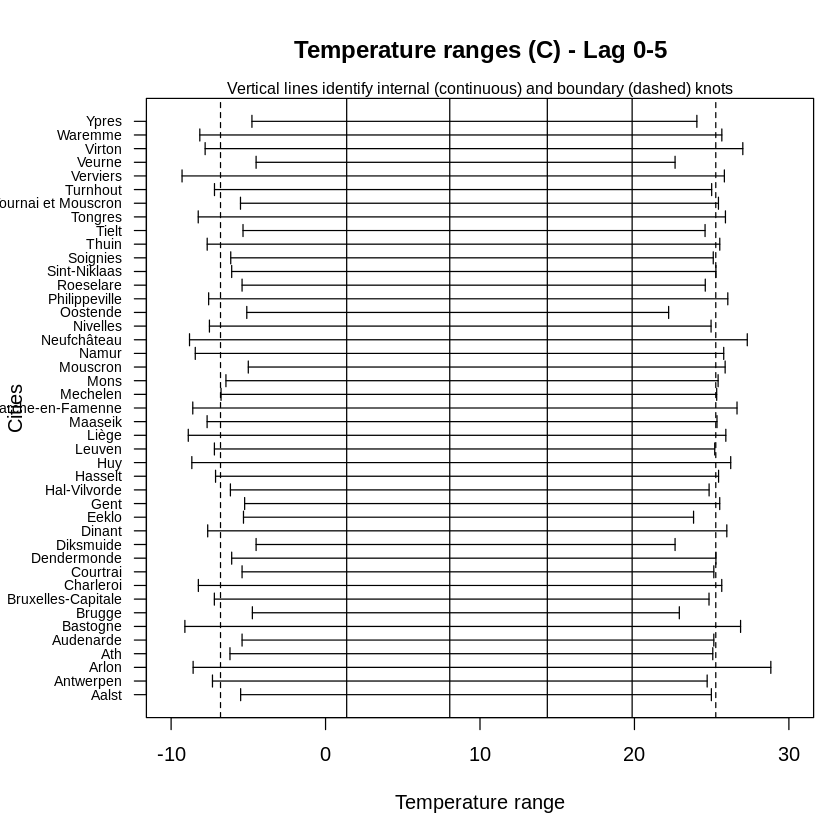

null device 
          1

null device 
          1

null device 
          1

null device 
          1

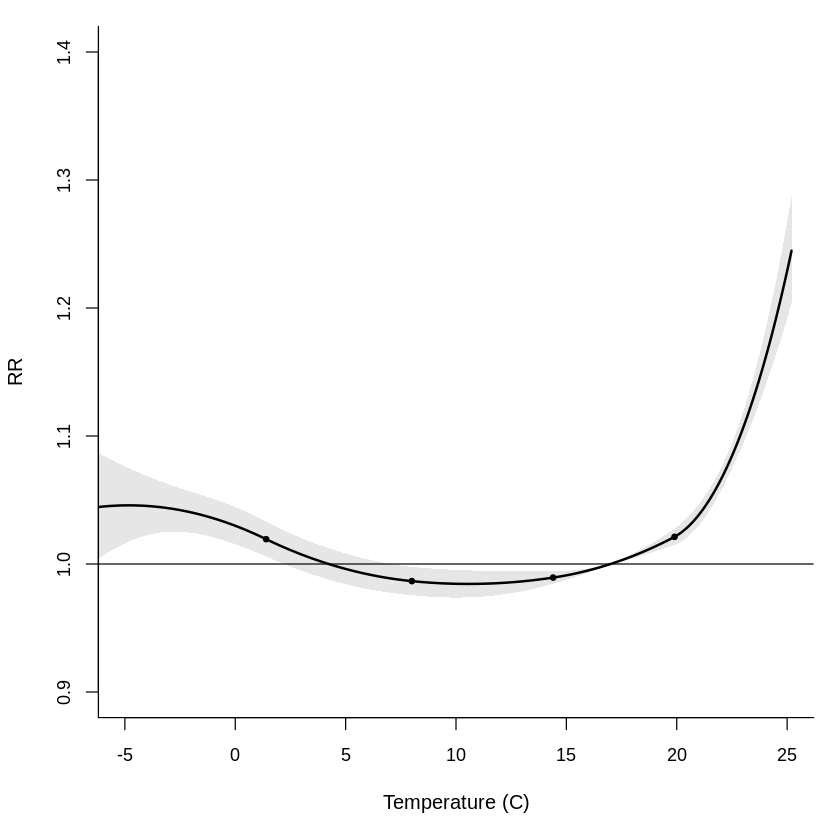

In [8]:
####################################################################
# TEMPERATURE RANGES
####################################################################

par(mar = c(5, 6, 4, 1)+0.1)
layout(1)
plot(seq(-10, 30, length = m),
     seq(m),
     type = "n",
     yaxt = "n",
     ylab = "",
     xlab = "Temperature range",
     main = "Temperature ranges (C) - Lag 0-5")
axis(2, at = seq(m), labels = regions, las = 1, cex.axis = 0.7)
arrows(ranges[, 1], seq(m), ranges[, 2], seq(m), angle = 90, length = 0.05, code = 3)
title(ylab = "Cities", mgp = c(5, 1, 0))
abline(v = knots)
abline(v = bound, lty = 2)
mtext("Vertical lines identify internal (continuous) and boundary (dashed) knots",
      cex = 0.8)

####################################################################
# GENERATE FIRST PART OF TABLE SIMILAR TO TABLE 2 IN THE MANUSCRIPT
####################################################################

tab2 <- matrix(NA, 4, 12)
colnames(tab2) <- c("Q", "df", "p", "I-square", "AIC", "BIC", "stat", "df",
                    "p", "stat", "df", "p")
rownames(tab2) <- c("intercept-only", "with latitude", "rel intercept-only",
                    "rel with latitude")

# FUNCTION TO COMPUTE THE STATISTICS FOR EACH MODEL
# THESE COMPUTATIONS ARE LIKELY TO BE REPLACED BY PROPER anova METHODS IN
#   FUTURE RELEASES OF THE PACKAGE
ftab <- function(m, mref=NULL) {
  # HETEROGENEITY AND IC STATS
  q <- qtest(m)
  het <- c(q$Q[1], 
           q$df[1], 
           q$pvalue[1], 
           (q$Q[1]-q$df[1])/q$Q[1]*100, 
           AIC(m),
           BIC(m))
  # LR TEST (ONLY FOR META-REGRESSION)
  if(!is.null(mref)) {
    lrstat <- -2*(logLik(mref) - logLik(m))[1]
    df <- attr(logLik(m), "df") - attr(logLik(mref), "df")
    pvalue <- 1 - pchisq(lrstat, df)
    lr <- c(lrstat, df, pvalue)
  }
  # WALD TEST (ONLY FOR META-REGRESSION)
  if(!is.null(mref)) {
    coef <- coef(m)[-grep("Int", names(coef(m)))]
    vcov <- vcov(m)[-grep("Int", names(coef(m))), -grep("Int", names(coef(m)))]
    waldstat <- coef %*% solve(vcov) %*% coef
    df <- length(coef)
    pvalue <- 1 - pchisq(waldstat, df)
    wald <- c(waldstat, df, pvalue)
  }
  # RESULTS
  if(!is.null(mref)) {
    return(c(het, lr, wald))
  } else return(c(het, rep(NA, 6))) 
}

tab2[1,] <- ftab(mv)
tab2[2,] <- ftab(mvlat, mv)

# THE TABLE WILL BE COMPLETED LATER

####################################################################
# POOLED RELATIONSHIP
####################################################################

# pdf("pooled_mhv.pdf", width = 5.6, height = 3.8)
# SET par OPTIONS
par(mar = c(5, 4, 1, 1) + 0.1, cex.axis = 0.9)
layout(1)

plot(cp, "overall",
     col=1,
     lwd=2,
     ylab="RR",
     ylim=c(.9,1.4),
     xlim=c(-5,25),
     xlab="Temperature (C)")
points(round(knots, 1), cp$allRRfit[as.character(round(knots, 1))], pch = 19, cex = 0.6)

dev.off()

####################################################################
# BLUP
####################################################################

# pdf("bluptot_mhv.pdf", width = 11.2, height = 3.8)
# SET par OPTIONS AND MULTIPANEL
par(mar = c(5, 4, 1, 1) + 0.1, cex.axis = 0.9)
layout(matrix(1:2, 1, 2))

# WARNING FOR PREDICTION BEYOND BOUNDARIES SUPPRESSED
options(warn = -1)

# PLOT OF AVERAGE AND CITY-SPECIFIC ESTIMATES
plot(cp,
     "overall",
     type="n",
     ci="n",
     ylab="RR",
     ylim=c(.9,1.4),
     xlim=c(-5,25),
     xlim=range(ranges),
     xlab="Temperature (C)")
for(i in seq(m)) {
  # WARNING FOR PREDICTION BEYOND BOUNDARIES SUPPRESSED
  lines(crosspred(btmean,
                  coef=ymat[i,],
                  vcov=Slist[[i]],
                  model.link="log",
                  from=ranges[i,1],
                  to=ranges[i,2],
                  cen=cen),
        col=grey(0.8),
        lty=5)
}
lines(cp,"overall", col=1, lwd=2)
abline(h=1)
mtext("Study-specific", cex=1.3)

# PLOT OF AVERAGE AND BLUP ESTIMATES
blup <- blup(mv, vcov=TRUE)
plot(cp,
     "overall",
     type="n",
     ci="n",
     ylab="RR",
     ylim=c(.9,1.4),
     xlim=c(-5,25),
     xlim=range(ranges),
     xlab="Temperature (C)")
for(i in seq(m)) {
  # WARNING FOR PREDICTION BEYOND BOUNDARIES SUPPRESSED
  lines(crosspred(btmean,
                  coef=blup[[i]]$blup,
                  vcov=blup[[i]]$vcov,
                  model.link="log",
                  from=ranges[i,1],
                  to=ranges[i,2],
                  cen=cen),
        col=grey(0.8),
        lty=5)
}
lines(cp, "overall", col=1, lwd=2)
abline(h = 1)
mtext("BLUP", cex=1.3)

# RESET WARNING
options(warn=0)

dev.off()


# pdf("blupregion_mhv.pdf", width=11.2, height=3.8)
# SET par OPTIONS AND MULTIPANEL
par(mar=c(5, 4, 1, 1) + 0.1, cex.axis=0.9)
layout(matrix(1:2, 1, 2))

plot(cp,
     "overall",
     col=1,
     lwd=2,
     ylab="RR",
     ylim=c(.9,1.4),
     xlim=c(-5,25),
     ci="n",
     xlab="Temperature (C)")
lines(crosspred(btmean,
                coef=ymat["Namur",],
                vcov=Slist[["Namur"]],
                model.link="log",
                by=0.1,
                cen=cen),
      lty=4)
lines(crosspred(btmean,
                coef=blup[["Namur"]]$blup,
                vcov=blup[["Namur"]]$vcov,
                model.link="log",
                by=0.1,
                cen=cen),
      lty=5)
mtext("Namur",cex=1.3)
legend("top",
       c("Population-average","First-stage","BLUP"),
       lty=c(1,4,5),
       lwd=c(2,1,1),
       cex=0.8,
       inset=0.1,
       bty="n")

plot(cp,
     "overall",
     col=1,
     lwd=2,
     ylab="RR",
     ylim=c(.9,1.4),
     xlim=c(-5,25),
     ci="n",
     xlab="Temperature (C)")
lines(crosspred(btmean,
                coef=ymat["Leuven",],
                vcov=Slist[["Leuven"]],
                model.link="log",
                by=0.1,
                cen=cen),
      lty=4)
lines(crosspred(btmean,
                coef=blup[["Leuven"]]$blup,
                vcov=blup[["Leuven"]]$vcov,
                model.link="log",
                by=0.1,
                cen=cen),
      lty=5)
mtext("Leuven", cex=1.3)
legend("top",
       c("Population-average","First-stage","BLUP"),
       lty=c(1,4,5),
       lwd=c(2,1,1),
       cex=0.8,
       inset=0.1,
       bty="n")

dev.off()

####################################################################
# META-REGRESSION
####################################################################

# pdf("metareg_mhv.pdf", width=6, height=4)
# SET par OPTIONS AND MULTIPANEL
par(mar = c(5, 4, 1, 1) + 0.1, cex.axis=0.9)
layout(1)

plot(cplat25,
     "overall",
     type="n",
     ylab="RR",
     ylim=c(.9,1.4),
     xlim=c(-5,25),
     xlab="Temperature (C)",
     ci.arg=list(density=20, col=grey(0.7)))
lines(cplat25,
      "overall",
      col=1,
      lty=4,
      lwd=2)
lines(cplat75,
      "overall",
      col=1,
      lty=5,
      lwd=2,
      ci="area",
      ci.arg=list(density=20, angle=-45, col=grey(0.7)))
abline(h=1)
legend("top",
       paste(perclat),
       lty=c(4,5),
       lwd=2,
       cex=1,
       inset=0.1,
       bty="n",
       title="Latitude (degree North)")

dev.off()

#
